### Convergence of WMT calculation at small dl
Example in box initialized with linear stratification and subject to vertical diffusion

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xarrayutils import vertical_coordinates as vc

In [105]:
## LOAD DATA
vgrid = 'native'
averaging = '6h'

# Time-mean tendencies
rootdir = '/archive/gam/MOM6-gm/ocean_only/box/dev_core/'+averaging+'/'
filename = 'ocean_'+vgrid+'.nc'
ds = xr.open_dataset(rootdir+filename)
# Time steps
delta_t = ds['average_DT'].astype('timedelta64[s]')
# Grid
filename_grid = 'ocean_static.nc'
grid = xr.open_dataset(rootdir+filename_grid)
# Constants
cp = 3992.0
rho0 = 1035.0

# Snapshots
filename_snap = 'ocean_'+vgrid+'_snap.nc'
ds_snap = xr.open_dataset(rootdir+filename_snap)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FileNotFoundError: [Errno 2] No such file or directory: b'/archive/gam/MOM6-gm/ocean_only/box/dev_core/6h/19000101.ocean_static.nc'

### Specify the depth of layers on the native grid
This is done for the time-mean fields and the snapshot fields

In [14]:
### Time-mean properties
nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}] # Scalar defining contours
h = ds['thkcello'][{'time':slice(1,nt)}] # Thickness
ps = (ds['opottempdiff'][{'time':slice(1,nt)}]/cp).to_dataset() # Diffusive processes changing l

# Get the depth of the layers on the native grid
z_i = xr.concat([xr.zeros_like(h.isel(zl=0)),h.cumsum(dim='zl')],dim='zl')
z_i = z_i.rename({'zl':'zi'})
z_i_vals = z_i.values
z_l_vals = 0.5*(z_i_vals[:,:,:,:-1]+z_i_vals[:,:,:,1:])
z_l = xr.DataArray(z_l_vals,dims=['time','yh','xh','zl'],coords={'time':l['time'],'xh':l['xh'],'yh':l['yh'],'zl':l['zl']})

### Snap-shots
l_snap = ds_snap['temp']
h_snap = ds_snap['thkcello']

# Get the depth of the layers on the native grid
z_snap_i = xr.concat([xr.zeros_like(h_snap.isel(zl=0)),h_snap.cumsum(dim='zl')],dim='zl')
z_snap_i = z_snap_i.rename({'zl':'zi'})
z_snap_i_vals = z_snap_i.values
z_snap_l_vals = 0.5*(z_snap_i_vals[:,:,:,:-1]+z_snap_i_vals[:,:,:,1:])
z_snap_l = xr.DataArray(z_snap_l_vals,dims=['time','yh','xh','zl'],coords={'time':z_snap_i.time,'xh':z_snap_i.xh,'yh':z_snap_i.yh,'zl':l['zl']})

### Evaluate the residual of the WMT calculation for varying dl
This is done in a rather inefficient way - redoing the interpolation (time-consuming) for every new dl. However, it's done here for simplicity and consistency (more efficient ways, e.g. interpolating once then taking subset contours) also has inherent challenges).

In [60]:
### Wrapper function to do watermass transformation from linear interpolation onto l contours
def calc_wmt_linearinterp(l,ps,z_l,z_i,l_snap,z_snap_l,z_snap_i,delta_l,area,rho0=1035):
    ## Find the depths of l contours via linear interpolation
    ### High resolution in l
    print('Calculating WMT with linear interpolation, delta_l = '+str(delta_l)+':')
    l_i_vals = np.arange(-1,11,delta_l)
    l_l_vals = 0.5*(l_i_vals[1:]+l_i_vals[:-1])

    # Flip the order of the temperature bins
    l_i = np.flip(l_i_vals)
    l_i = xr.DataArray(l_i,coords={l.name+'_bin':l_i},dims=l.name+'_bin')
    l_l = np.flip(l_l_vals)
    l_l = xr.DataArray(l_l,coords={l.name+'_bin':l_l},dims=l.name+'_bin')

    ### Time-mean
    print('   Finding depths of layer interfaces (time-mean fields)...')
    l_i_depth = vc.linear_interpolation_regrid(z = z_l,
                                               data = l,
                                               target_values = l_i,
                                               z_bounds = z_i,
                                               target_value_dim = l.name+'_bin',
                                               z_bounds_dim='zi',
                                               z_dim='zl')
    print('   Finding depths of l contours (snapshot fields)...')
    l_snap_l_depth = vc.linear_interpolation_regrid(z = z_snap_l,
                                               data = l_snap,
                                               target_values = l_l,
                                               z_bounds = z_snap_i,
                                               target_value_dim = l.name+'_bin',
                                               z_bounds_dim='zi',
                                               z_dim='zl')

    #### Calculation of E ####
    ### Remap properties to new l-contour grid
    # Necessary only for the time-mean properties
    # A little hacky to recover vertically integrated quantities (as opposed to layer mean quantities as is currently output by vc algorithm)
    # 1. Convert tendency to pseudo-intensive quantity
    # 2. Conservative remap
    # 3. Muliply by new layer thickness
    print('   Remapping tendencies into l layers...')
    ps_remap=xr.Dataset()
    for term in ps.data_vars:
        print(term)
        dz_orig = z_i.diff('zi').rename({'zi':'zl'})
        ps_intensive = ps[term]/dz_orig
        ps_intensive_remapped = vc.conservative_remap(data=ps_intensive,z_bnds_source=z_i, z_bnds_target=l_i_depth,
                                       z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
        ps_intensive_remapped = ps_intensive_remapped.assign_coords(remapped=np.flip(l_l_vals))
        dz_targ = l_i_depth.diff('regridded').rename({'regridded':'remapped'}).assign_coords(remapped=np.flip(l_l_vals))
        ps_remap[term] = ps_intensive_remapped*dz_targ
    ps_remap = ps_remap.rename({'remapped':l.name+'_bin'})

    print('   Integrating tendencies within layers to get E...')
    E = (ps_remap['opottempdiff']*grid.areacello).sum(['xh','yh'])/delta_l

    #### Calculation of dVdt ####
    print('   Calcualting dVdt from change in contour depth...')
    # We can calculate the volume change in time from the change in interface depth
    dVdt = (rho0*l_snap_l_depth*area).sum(['xh','yh']).diff('time')/(6*60*60)
    dVdt = dVdt.rename({'regridded':l.name+'_bin'}).assign_coords(time=E['time'])

    print('   Calculating residual...')
    residual = dVdt-E
    print('... done.')

    return E,dVdt,residual

In [90]:
E = {}
dVdt = {}
residual = {}
dls = [1,0.5,0.25,0.1,0.05,0.01]
for delta_l in dls:
    E[delta_l],dVdt[delta_l],residual[delta_l] = calc_wmt_linearinterp(l,ps,z_l,z_i,l_snap,z_snap_l,z_snap_i,delta_l,area=grid.areacello,rho0=rho0)

Calculating WMT with linear interpolation, delta_l = 1:
   Finding depths of layer interfaces (time-mean fields)...
   Finding depths of l contours (snapshot fields)...
   Remapping tendencies into l layers...
opottempdiff
   Integrating tendencies within layers to get E...
   Calcualting dVdt from change in contour depth...
   Calculating residual...
... done.
Calculating WMT with linear interpolation, delta_l = 0.5:
   Finding depths of layer interfaces (time-mean fields)...
   Finding depths of l contours (snapshot fields)...
   Remapping tendencies into l layers...
opottempdiff
   Integrating tendencies within layers to get E...
   Calcualting dVdt from change in contour depth...
   Calculating residual...
... done.
Calculating WMT with linear interpolation, delta_l = 0.25:
   Finding depths of layer interfaces (time-mean fields)...
   Finding depths of l contours (snapshot fields)...
   Remapping tendencies into l layers...
opottempdiff
   Integrating tendencies within layers to g

### Figures

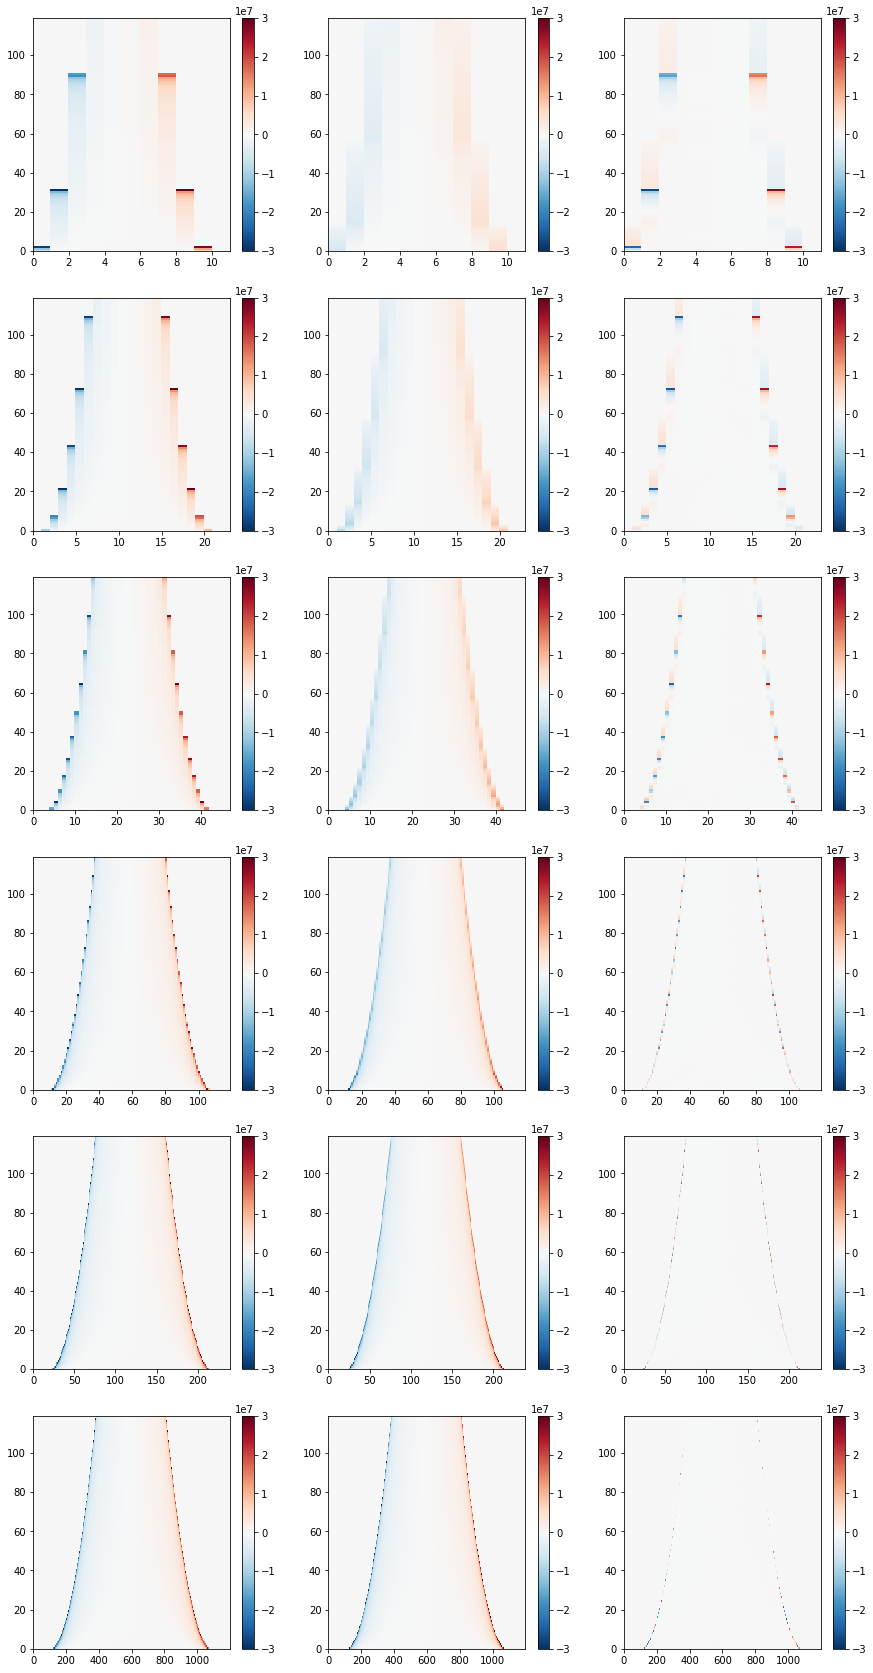

In [95]:
ndl = len(dls)
vmin=-3E7
vmax=3E7
fig,ax = plt.subplots(figsize = (5*3,5*ndl),nrows=ndl,ncols=3)
count=0
for delta_l in dls:
    im = ax[count,0].pcolormesh(dVdt[delta_l],cmap='RdBu_r',vmin=vmin,vmax=vmax)
    plt.colorbar(im,ax=ax[count,0])
    im = ax[count,1].pcolormesh(E[delta_l],cmap='RdBu_r',vmin=vmin,vmax=vmax)
    plt.colorbar(im,ax=ax[count,1])
    im = ax[count,2].pcolormesh(residual[delta_l],cmap='RdBu_r',vmin=vmin,vmax=vmax)
    plt.colorbar(im,ax=ax[count,2])
    count+=1

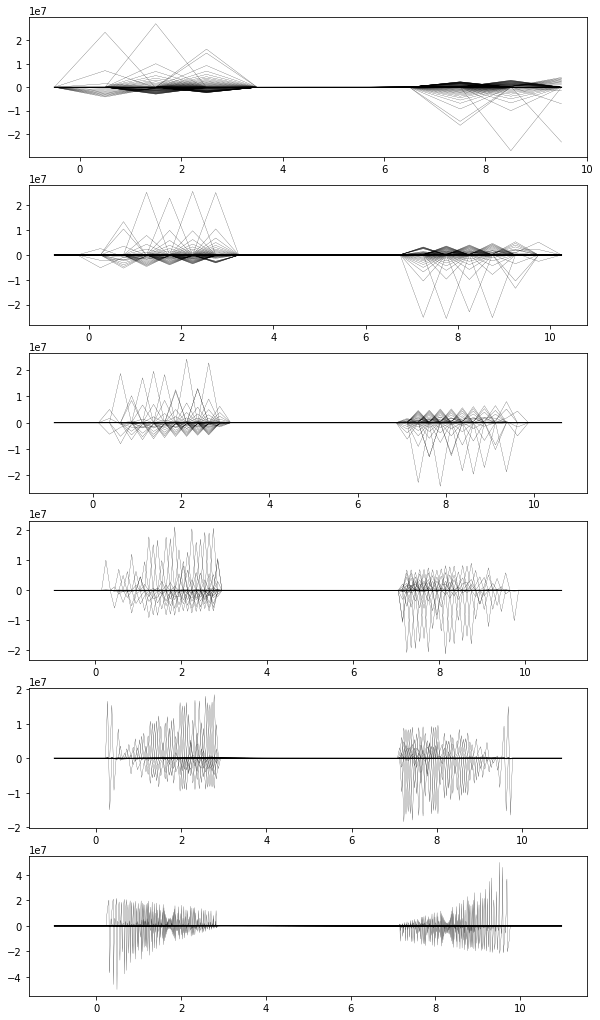

In [92]:
nt = len(residual[0.5]['time'])
ndl = len(dls)
fig,ax = plt.subplots(figsize = (10,3*ndl),nrows=ndl)
count=0
for delta_l in dls:
    for t in range(nt):
        ax[count].plot(residual[delta_l][l.name+'_bin'],residual[delta_l].isel(time=t),'k-',linewidth=0.2)
    ax[count].plot(residual[delta_l][l.name+'_bin'],residual[delta_l].mean('time'),'k-',linewidth=1)
    count+=1

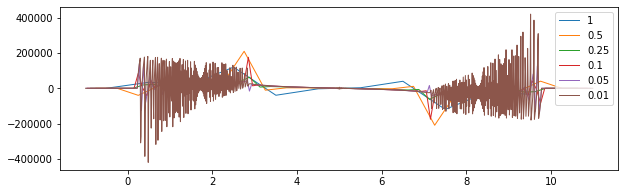

In [93]:
nt = len(residual[0.5]['time'])
ndl = len(dls)
fig,ax = plt.subplots(figsize = (10,3))
for delta_l in dls:
    ax.plot(residual[delta_l][l.name+'_bin'],residual[delta_l].mean('time'),linewidth=1,label=str(delta_l))
ax.legend()

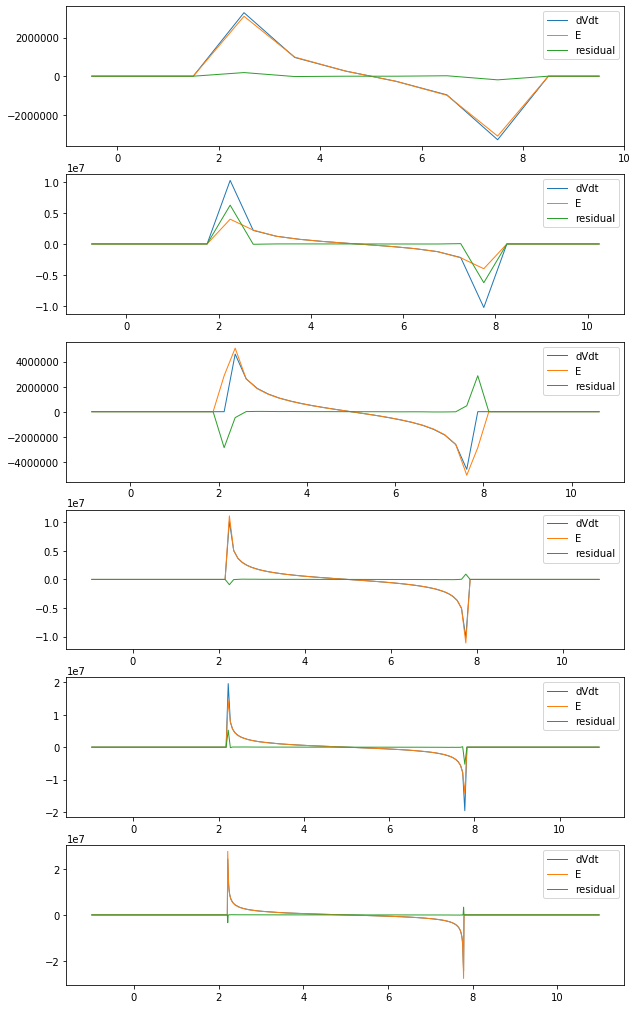

In [104]:
t=70
ndl = len(dls)
fig,ax = plt.subplots(figsize = (10,3*ndl),nrows=ndl)
count=0
for delta_l in dls:
    ax[count].plot(dVdt[delta_l][l.name+'_bin'],dVdt[delta_l].isel(time=t),linewidth=1,label='dVdt')
    ax[count].plot(E[delta_l][l.name+'_bin'],E[delta_l].isel(time=t),linewidth=1,label='E')
    ax[count].plot(residual[delta_l][l.name+'_bin'],residual[delta_l].isel(time=t),linewidth=1,label='residual')
    ax[count].legend()
    count+=1

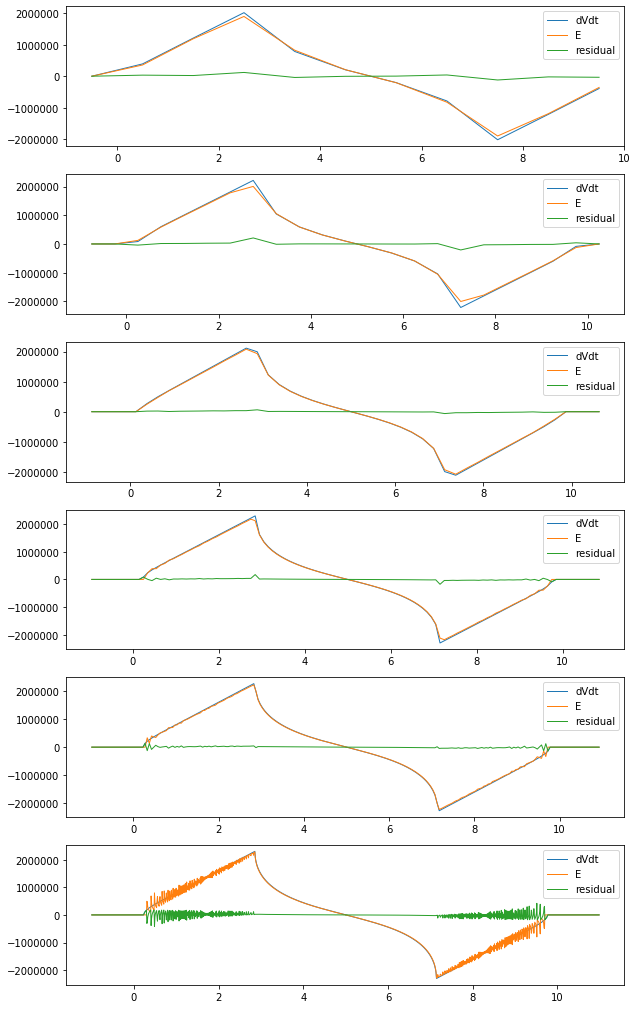

In [94]:
ndl = len(dls)
fig,ax = plt.subplots(figsize = (10,3*ndl),nrows=ndl)
count=0
for delta_l in dls:
    ax[count].plot(dVdt[delta_l][l.name+'_bin'],dVdt[delta_l].mean('time'),linewidth=1,label='dVdt')
    ax[count].plot(E[delta_l][l.name+'_bin'],E[delta_l].mean('time'),linewidth=1,label='E')
    ax[count].plot(residual[delta_l][l.name+'_bin'],residual[delta_l].mean('time'),linewidth=1,label='residual')
    ax[count].legend()
    count+=1